# End to end walkthrough

https://nixtlaverse.nixtla.io/mlforecast/docs/getting-started/end_to_end_walkthrough.html

In [ ]:
import random
import tempfile
from pathlib import Path

import pandas as pd
from datasetsforecast.m4 import M4
from utilsforecast.plotting import plot_series

In [ ]:
await M4.async_download('data', group='Hourly')
df, *_ = M4.load('data', 'Hourly')
uids = df['unique_id'].unique()
random.seed(0)
sample_uids = random.choices(uids, k=4)
df = df[df['unique_id'].isin(sample_uids)].reset_index(drop=True)
df['ds'] = df['ds'].astype('int64')
df

,unique_id,ds,y
0,H196,1,11.8
1,H196,2,11.4
2,H196,3,11.1
3,H196,4,10.8
4,H196,5,10.6
...,...,...,...
4027,H413,1004,99.0
4028,H413,1005,88.0
4029,H413,1006,47.0
4030,H413,1007,41.0


In [ ]:
df['unique_id'].value_counts()

unique_id
H196    1008
H256    1008
H381    1008
H413    1008
Name: count, dtype: int64

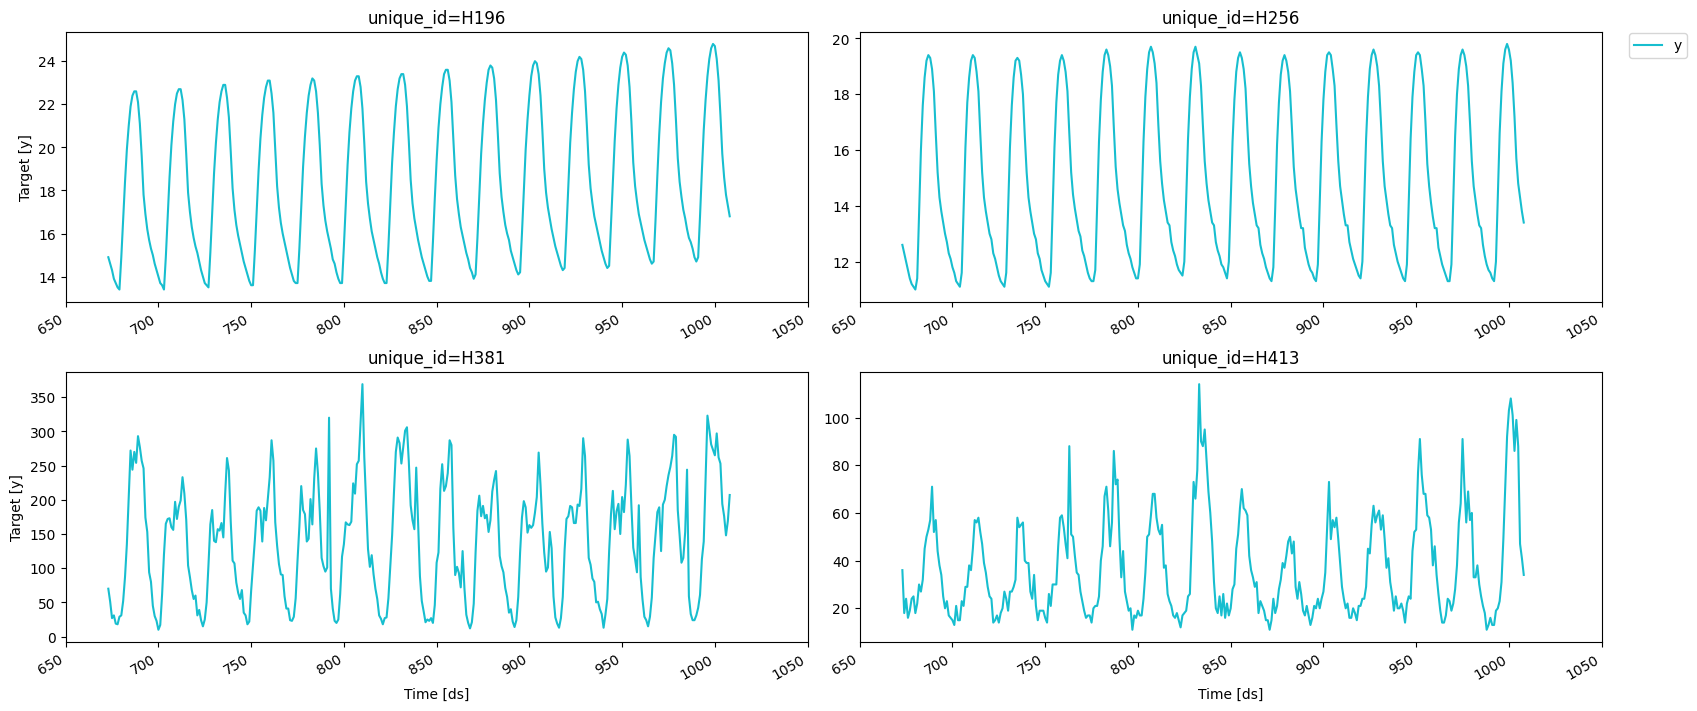

In [ ]:
plot_series(df, max_insample_length=24 * 14)

In [ ]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

In [ ]:
fcst = MLForecast(
    models=[],  # we're not interested in modeling yet
    freq=1,  # our series have integer timestamps, so we'll just add 1 in every timestep
    target_transforms=[Differences([24])],
)
prep = fcst.preprocess(df)
prep

,unique_id,ds,y
24,H196,25,0.3
25,H196,26,0.3
26,H196,27,0.1
27,H196,28,0.2
28,H196,29,0.2
...,...,...,...
4027,H413,1004,39.0
4028,H413,1005,55.0
4029,H413,1006,14.0
4030,H413,1007,3.0


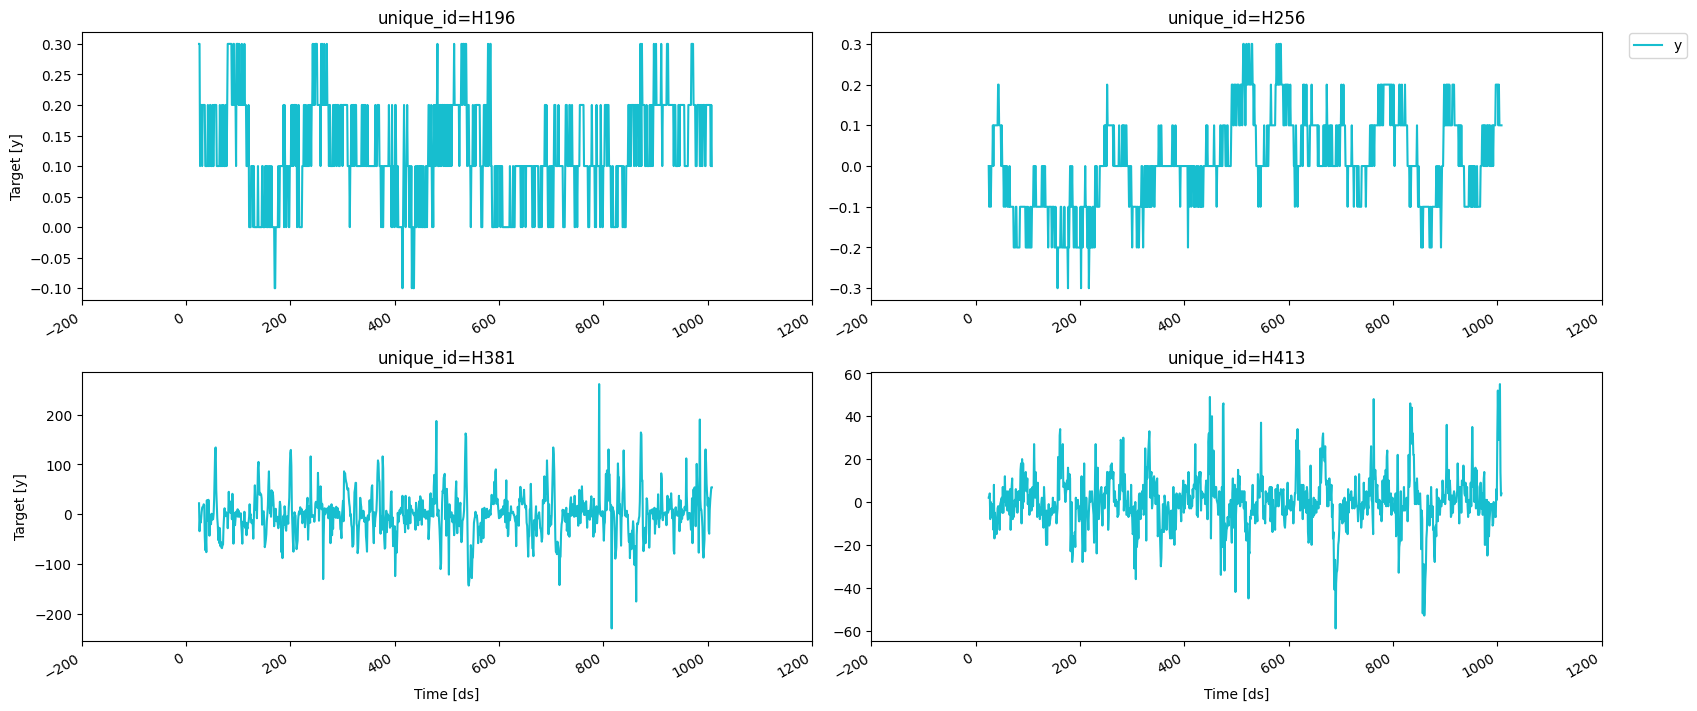

In [ ]:
plot_series(prep)

In [ ]:
fcst = MLForecast(
    models=[],
    freq=1,
    lags=[1, 24],
    target_transforms=[Differences([24])],    
)
prep = fcst.preprocess(df)
prep

,unique_id,ds,y,lag1,lag24
48,H196,49,0.1,0.1,0.3
49,H196,50,0.1,0.1,0.3
50,H196,51,0.2,0.1,0.1
51,H196,52,0.1,0.2,0.2
52,H196,53,0.1,0.1,0.2
...,...,...,...,...,...
4027,H413,1004,39.0,29.0,1.0
4028,H413,1005,55.0,39.0,-25.0
4029,H413,1006,14.0,55.0,-20.0
4030,H413,1007,3.0,14.0,0.0


In [ ]:
prep.drop(columns=['unique_id', 'ds']).corr()['y']

y        1.000000
lag1     0.622531
lag24   -0.234268
Name: y, dtype: float64

In [ ]:
from mlforecast.lag_transforms import ExpandingMean, RollingMean

from numba import njit
from window_ops.rolling import rolling_mean

In [ ]:
@njit
def rolling_mean_48(x):
    return rolling_mean(x, window_size=48)


fcst = MLForecast(
    models=[],
    freq=1,
    target_transforms=[Differences([24])],    
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48), rolling_mean_48],
    },
)
prep = fcst.preprocess(df)
prep

,unique_id,ds,y,expanding_mean_lag1,rolling_mean_lag24_window_size48,rolling_mean_48_lag24
95,H196,96,0.1,0.174648,0.150000,0.150000
96,H196,97,0.3,0.173611,0.145833,0.145833
97,H196,98,0.3,0.175342,0.141667,0.141667
98,H196,99,0.3,0.177027,0.141667,0.141667
99,H196,100,0.3,0.178667,0.141667,0.141667
...,...,...,...,...,...,...
4027,H413,1004,39.0,0.242084,3.437500,3.437500
4028,H413,1005,55.0,0.281633,2.708333,2.708333
4029,H413,1006,14.0,0.337411,2.125000,2.125000
4030,H413,1007,3.0,0.351324,1.770833,1.770833


In [ ]:
def hour_index(times):
    return times % 24

fcst = MLForecast(
    models=[],
    freq=1,
    target_transforms=[Differences([24])],
    date_features=[hour_index],
)
fcst.preprocess(df)

,unique_id,ds,y,hour_index
24,H196,25,0.3,1
25,H196,26,0.3,2
26,H196,27,0.1,3
27,H196,28,0.2,4
28,H196,29,0.2,5
...,...,...,...,...
4027,H413,1004,39.0,20
4028,H413,1005,55.0,21
4029,H413,1006,14.0,22
4030,H413,1007,3.0,23


In [ ]:
from mlforecast.target_transforms import LocalStandardScaler

In [ ]:
fcst = MLForecast(
    models=[],
    freq=1,
    lags=[1],
    target_transforms=[LocalStandardScaler()]
)
fcst.preprocess(df)

,unique_id,ds,y,lag1
1,H196,2,-1.493026,-1.383286
2,H196,3,-1.575331,-1.493026
3,H196,4,-1.657635,-1.575331
4,H196,5,-1.712505,-1.657635
5,H196,6,-1.794810,-1.712505
...,...,...,...,...
4027,H413,1004,3.062766,2.425012
4028,H413,1005,2.523128,3.062766
4029,H413,1006,0.511751,2.523128
4030,H413,1007,0.217403,0.511751


In [ ]:
from sklearn.base import BaseEstimator

class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

In [ ]:
fcst = MLForecast(
    models=[Naive()],
    freq=1,
    lags=[1],
    target_transforms=[LocalStandardScaler()]
)
fcst.fit(df)
preds = fcst.predict(1)
preds

,unique_id,ds,Naive
0,H196,1009,16.8
1,H256,1009,13.4
2,H381,1009,207.0
3,H413,1009,34.0


In [ ]:
last_vals = df.groupby('unique_id').tail(1)
last_vals

,unique_id,ds,y
1007,H196,1008,16.8
2015,H256,1008,13.4
3023,H381,1008,207.0
4031,H413,1008,34.0


In [ ]:
import numpy as np

In [ ]:
np.testing.assert_allclose(preds['Naive'], last_vals['y'])

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_params = {
    'verbosity': -1,
    'num_leaves': 512,
}

fcst = MLForecast(
    models={
        'avg': lgb.LGBMRegressor(**lgb_params),
        'q75': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
        'q25': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
    },
    freq=1,
    target_transforms=[Differences([24])],
    lags=[1, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=[hour_index],
)
fcst.fit(df)

MLForecast(models=[avg, q75, q25], freq=1, lag_features=['lag1', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=[<function hour_index>], num_threads=1)

In [ ]:
preds = fcst.predict(48)
preds

,unique_id,ds,avg,q75,q25
0,H196,1009,16.295257,16.357148,16.315731
1,H196,1010,15.910282,16.007322,15.862261
2,H196,1011,15.728367,15.780183,15.658180
3,H196,1012,15.468414,15.513598,15.399717
4,H196,1013,15.081279,15.133848,15.007694
...,...,...,...,...,...
187,H413,1052,100.450617,124.211150,47.025017
188,H413,1053,88.426800,108.303409,44.715380
189,H413,1054,59.675737,81.859964,19.239462
190,H413,1055,57.580356,72.703301,21.486674


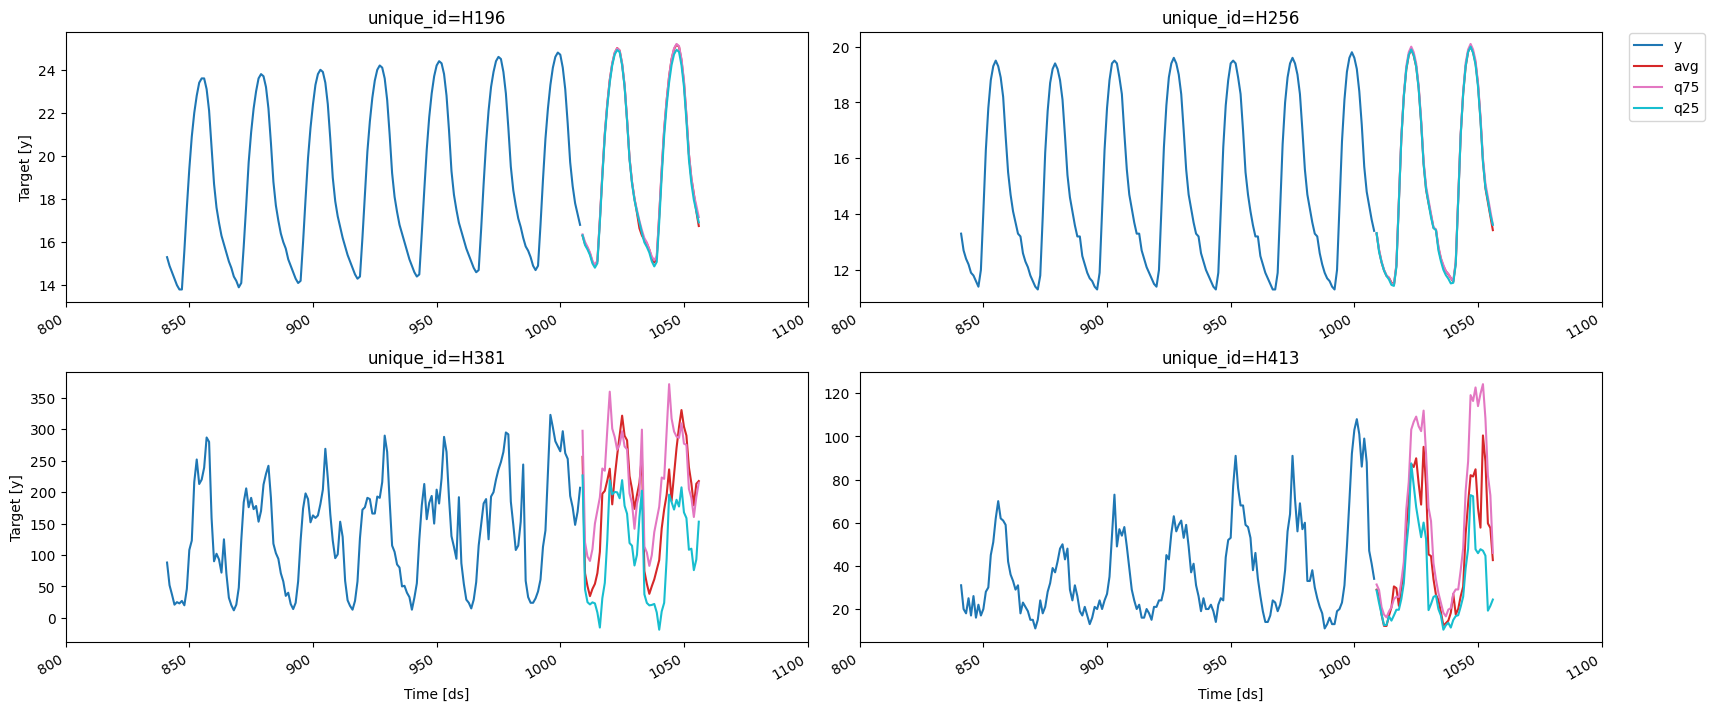

In [ ]:
plot_series(df, preds, max_insample_length=24 * 7)

In [ ]:
with tempfile.TemporaryDirectory() as tmpdir:
    save_dir = Path(tmpdir) / 'mlforecast'
    fcst.save(save_dir)
    fcst2 = MLForecast.load(save_dir)
    preds2 = fcst2.predict(48)
    pd.testing.assert_frame_equal(preds, preds2)

In [ ]:
fcst = MLForecast(
    models=[Naive()],
    freq=1,
    lags=[1, 2, 3],
)
fcst.fit(df)
fcst.predict(1)

,unique_id,ds,Naive
0,H196,1009,16.8
1,H256,1009,13.4
2,H381,1009,207.0
3,H413,1009,34.0


In [ ]:
new_values = pd.DataFrame({
    'unique_id': ['H196', 'H256'],
    'ds': [1009, 1009],
    'y': [17.0, 14.0],
})
fcst.update(new_values)
preds = fcst.predict(1)
preds

,unique_id,ds,Naive
0,H196,1010,17.0
1,H256,1010,14.0
2,H381,1009,207.0
3,H413,1009,34.0


In [ ]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(**lgb_params),
    freq=1,
    target_transforms=[Differences([24])],
    lags=[1, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=[hour_index],
)
cv_result = fcst.cross_validation(
    df,
    n_windows=4,  # number of models to train/splits to perform
    h=48,  # length of the validation set in each window
)
cv_result

,unique_id,ds,cutoff,y,LGBMRegressor
0,H196,817,816,15.3,15.383165
1,H196,818,816,14.9,14.923219
2,H196,819,816,14.6,14.667834
3,H196,820,816,14.2,14.275964
4,H196,821,816,13.9,13.973491
...,...,...,...,...,...
763,H413,1004,960,99.0,65.644823
764,H413,1005,960,88.0,71.717097
765,H413,1006,960,47.0,76.704377
766,H413,1007,960,41.0,53.446638


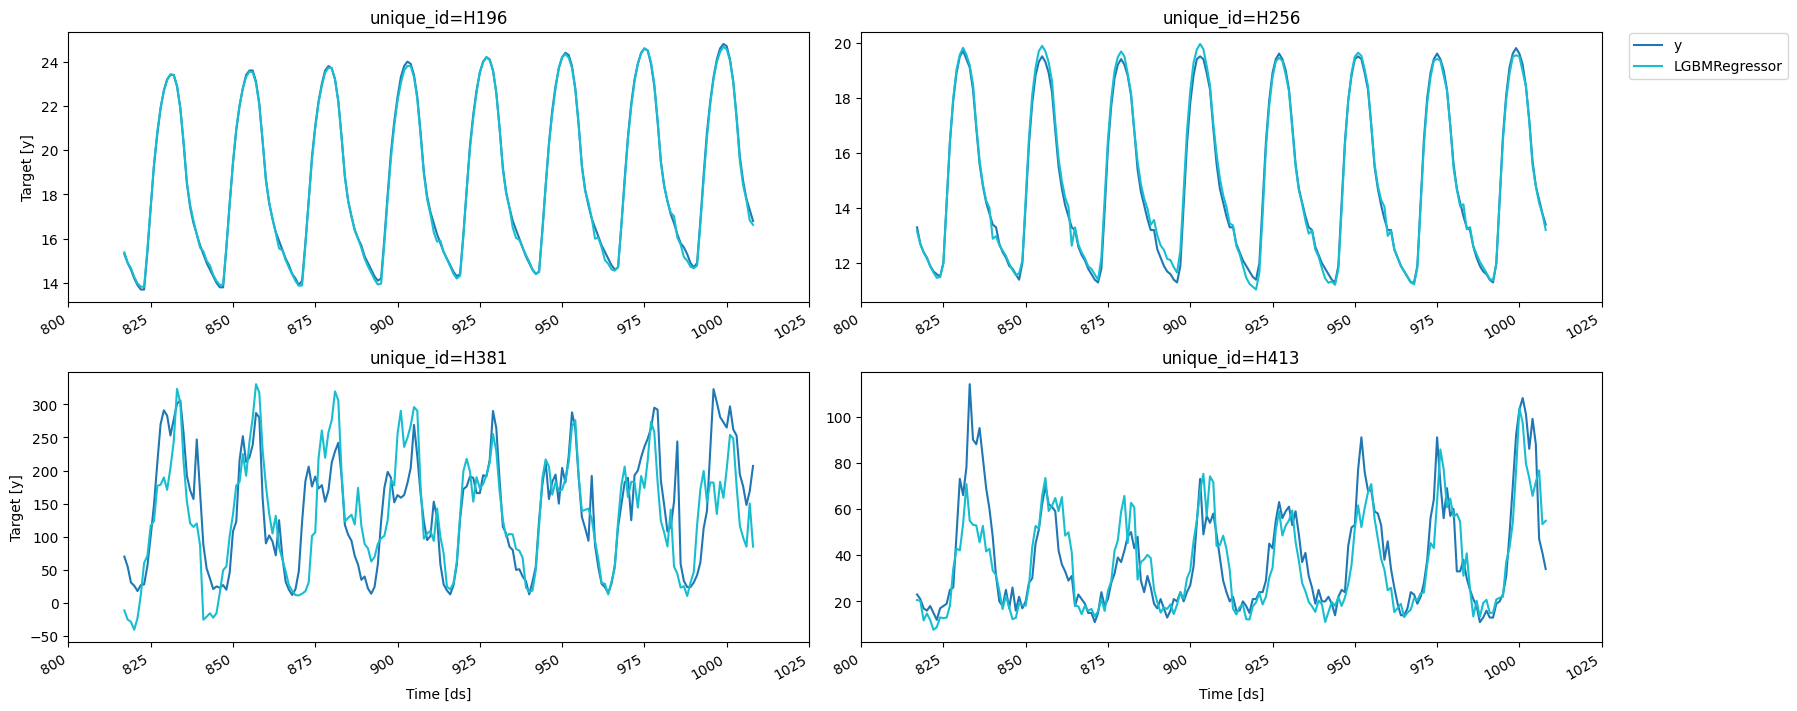

In [ ]:
plot_series(forecasts_df=cv_result.drop(columns='cutoff'))

In [ ]:
from utilsforecast.losses import rmse

In [ ]:
def evaluate_cv(df):
    return rmse(df, models=['LGBMRegressor'], id_col='cutoff').set_index('cutoff')

split_rmse = evaluate_cv(cv_result)
split_rmse

,LGBMRegressor
cutoff,
816,29.418172
864,34.257598
912,13.145763
960,35.066261


In [ ]:
split_rmse.mean()

LGBMRegressor    27.971949
dtype: float64

In [ ]:
from mlforecast.lag_transforms import ExponentiallyWeightedMean

In [ ]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(**lgb_params),
    freq=1,
    lags=[1, 24],
    lag_transforms={
        1: [ExponentiallyWeightedMean(alpha=0.5)],
        24: [RollingMean(window_size=48)],      
    },
    date_features=[hour_index],    
)
cv_result2 = fcst.cross_validation(
    df,
    n_windows=4,
    h=48,
)
evaluate_cv(cv_result2).mean()

LGBMRegressor    25.874439
dtype: float64

In [ ]:
from mlforecast.lgb_cv import LightGBMCV

In [ ]:
cv = LightGBMCV(
    freq=1,
    target_transforms=[Differences([24])],
    lags=[1, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=[hour_index],
    num_threads=2,
)
cv_hist = cv.fit(
    df,
    n_windows=4,
    h=48,
    params=lgb_params,
    eval_every=5,
    early_stopping_evals=5,    
    compute_cv_preds=True,
)

[5] mape: 0.158639
[10] mape: 0.163739
[15] mape: 0.161535
[20] mape: 0.169491
[25] mape: 0.163690
[30] mape: 0.164198
Early stopping at round 30
Using best iteration: 5


In [ ]:
cv.cv_preds_

,unique_id,ds,y,Booster,window
0,H196,817,15.3,15.473182,0
1,H196,818,14.9,15.038571,0
2,H196,819,14.6,14.849409,0
3,H196,820,14.2,14.448379,0
4,H196,821,13.9,14.148379,0
...,...,...,...,...,...
187,H413,1004,99.0,61.425396,3
188,H413,1005,88.0,62.886890,3
189,H413,1006,47.0,57.886890,3
190,H413,1007,41.0,38.849009,3


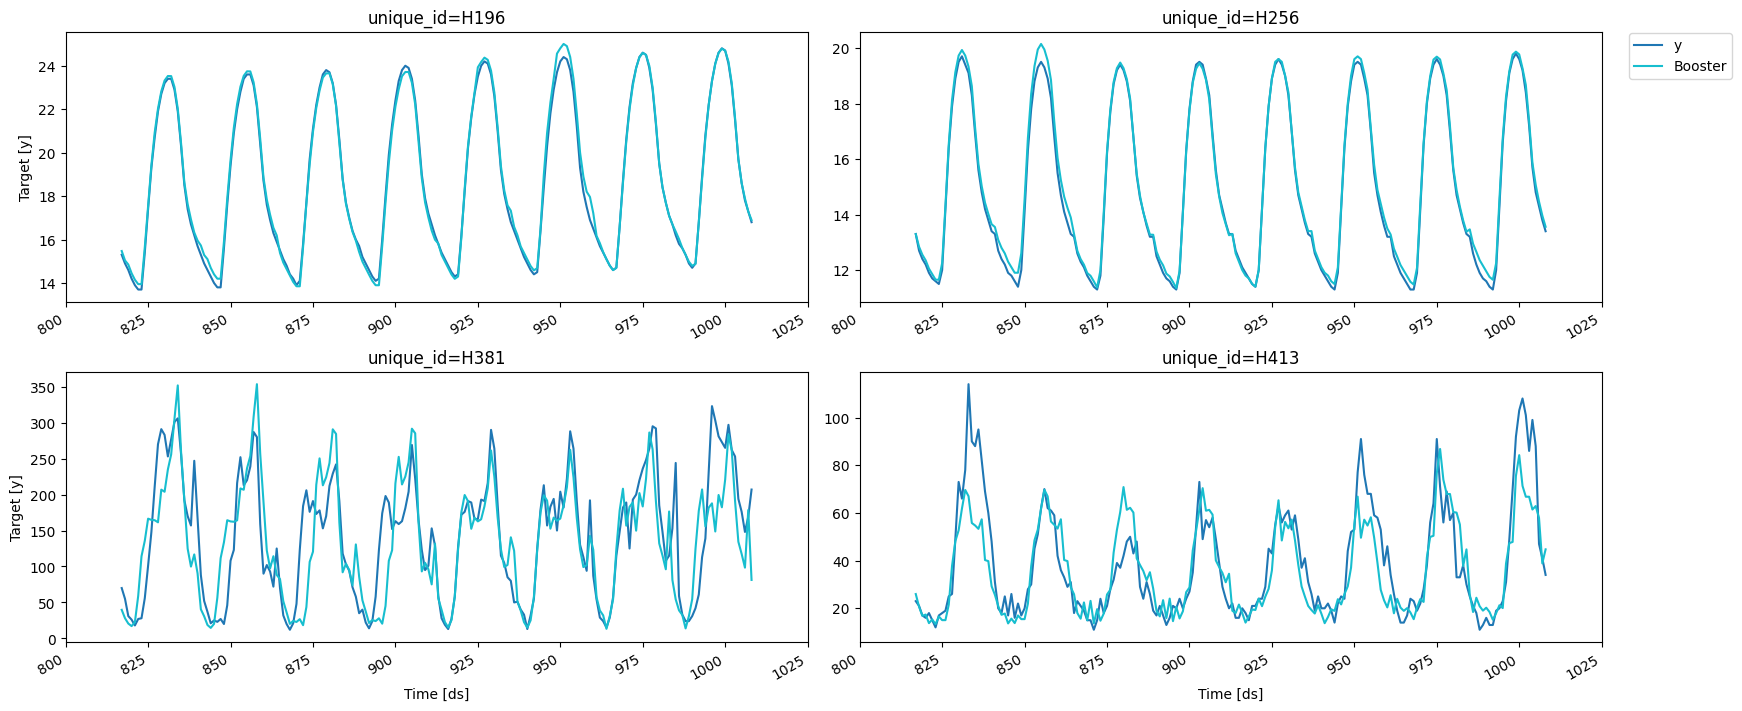

In [ ]:
plot_series(forecasts_df=cv.cv_preds_.drop(columns='window'))

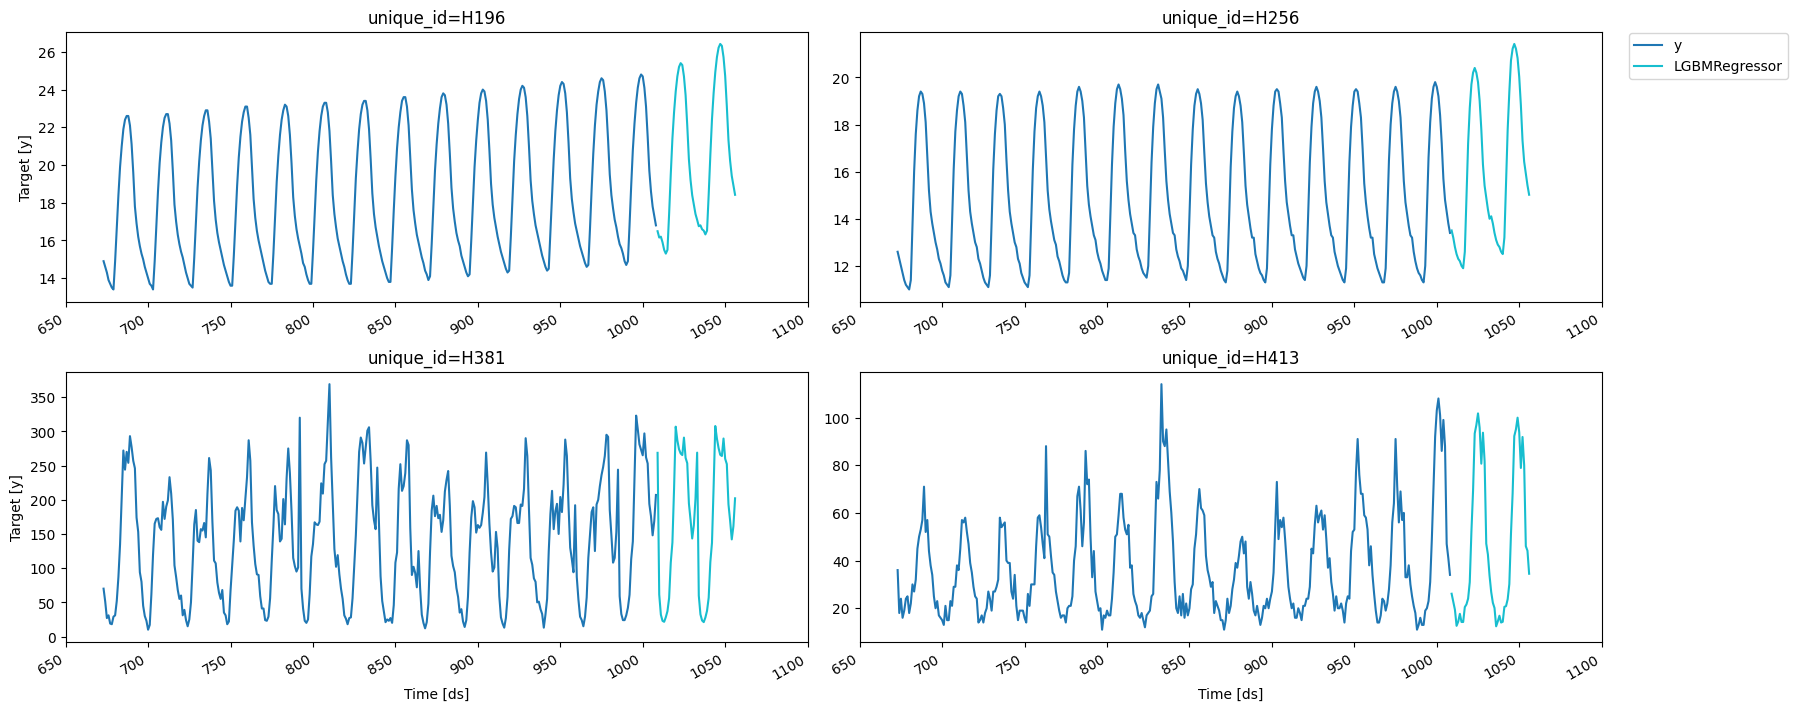

In [ ]:
final_fcst = MLForecast.from_cv(cv)
final_fcst.fit(df)
preds = final_fcst.predict(48)
plot_series(df, preds, max_insample_length=24 * 14)